In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import Conv1DTranspose, LSTM, RepeatVector, TimeDistributed, GaussianDropout
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical, plot_model

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import random

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

from PIL import Image
import glob
import datetime

IMG_WIDTH = IMG_HEIGHT = 128

ASPHALT_PIXEL = 29
ROAD_PIXEL = 76
SAND_ROAD_PIXEL = 150

ASPHALT_CLASS = 1
ROAD_CLASS = 2
SAND_ROAD_CLASS = 3

OUTPUT_CHANNELS = 4 # 3 road classes and 1 class for rest

In [2]:
final_img_paths =  sorted(glob.glob('../../output_final/*'))
raw_img_paths = glob.glob('../../Dane_Przykładowe/Photos/200MSDCF/*')

with open('./data/wrong_imgs/must.txt','r') as f:
    wrong_imgs = f.readlines()

wrong_img_names = [wrong_image.strip() for wrong_image in wrong_imgs if wrong_image.strip() != '']

In [3]:
def print_message_with_time(message: str):
    print(f'[{datetime.datetime.now().strftime("%H:%M:%S")}] {message}')

def read_imgs(final_image_paths, wrong_images, verbose = False):
    raw_imgs = []
    final_imgs = []

    for index, final_image_path in enumerate(final_image_paths):
        if verbose:
            print_message_with_time(f"Parsing {index+1}/{len(final_img_paths)}")

        image_name = final_image_path.split('/')[-1][4:-4]
        
        if image_name in wrong_images:
            continue

        raw_image_path = f'../../Dane_Przykładowe/Photos/200MSDCF/{image_name}.JPG'

        final_img = Image.open(final_image_path).convert('L')
        final_img = final_img.resize((IMG_WIDTH, IMG_HEIGHT), resample=Image.NEAREST)
        final_img = np.array(final_img)
        final_img[final_img == ASPHALT_PIXEL] = ASPHALT_CLASS
        final_img[final_img == ROAD_PIXEL] = ROAD_CLASS
        final_img[final_img == SAND_ROAD_PIXEL] = SAND_ROAD_CLASS
        final_imgs.append(final_img)

        raw_img = Image.open(raw_image_path).convert('RGB')
        raw_img = raw_img.resize((IMG_WIDTH, IMG_HEIGHT))
        raw_img = np.array(raw_img)
        raw_img = raw_img / 255
        raw_imgs.append(raw_img)

    return np.array(raw_imgs), np.array(final_imgs)

raw_imgs, final_imgs = read_imgs(final_img_paths, wrong_img_names, verbose=True)

[22:55:41] Parsing 1/450
[22:55:41] Parsing 2/450
[22:55:43] Parsing 3/450
[22:55:45] Parsing 4/450
[22:55:47] Parsing 5/450
[22:55:49] Parsing 6/450
[22:55:50] Parsing 7/450
[22:55:52] Parsing 8/450
[22:55:54] Parsing 9/450
[22:55:56] Parsing 10/450
[22:55:58] Parsing 11/450
[22:55:58] Parsing 12/450
[22:55:58] Parsing 13/450
[22:55:58] Parsing 14/450
[22:55:59] Parsing 15/450
[22:56:01] Parsing 16/450
[22:56:03] Parsing 17/450
[22:56:03] Parsing 18/450
[22:56:05] Parsing 19/450
[22:56:06] Parsing 20/450
[22:56:08] Parsing 21/450
[22:56:10] Parsing 22/450
[22:56:12] Parsing 23/450
[22:56:15] Parsing 24/450
[22:56:17] Parsing 25/450
[22:56:20] Parsing 26/450
[22:56:23] Parsing 27/450
[22:56:25] Parsing 28/450
[22:56:27] Parsing 29/450
[22:56:29] Parsing 30/450
[22:56:31] Parsing 31/450
[22:56:33] Parsing 32/450
[22:56:34] Parsing 33/450
[22:56:36] Parsing 34/450
[22:56:38] Parsing 35/450
[22:56:40] Parsing 36/450
[22:56:42] Parsing 37/450
[22:56:45] Parsing 38/450
[22:56:47] Parsing 39

In [6]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Y, valid_Y = train_test_split(raw_imgs, final_imgs, train_size=0.8, random_state=SEED)

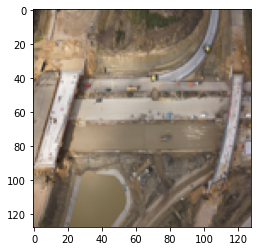

In [11]:
plt.imshow(train_X[0])

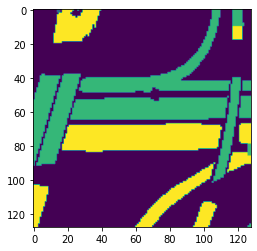

In [10]:

plt.imshow(train_Y[0])

In [55]:
np.unique(train_Y, return_counts=True)


(array([0, 1, 2, 3], dtype=uint8), array([3543184,  114155,  501581,  264760]))

In [73]:
class_weights = np.copy(train_Y)
class_weights[class_weights == 1] = 3543184 / 114155
class_weights[class_weights == 2] = 3543184 / 501581
class_weights[class_weights == 3] = 3543184 / 264760
class_weights[class_weights == 0] = 1

In [79]:
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y, class_weights))
dataset = dataset.shuffle(buffer_size=1024).batch(32)
# SPLITTING DATASET
def is_test(x, _):
    return x % 10 == 0


def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

validation_dataset = dataset.enumerate().filter(is_test).map(recover)
train_dataset = dataset.enumerate().filter(is_train).map(recover)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(dataset, epochs=1000, batch_size=64, validation_data=validation_dataset, callbacks= [
    EarlyStopping(min_delta=0.0001, patience=3)
])

Epoch 1/1000
9/9 [==============================] - 21s 2s/step - loss: 4.8142 - accuracy: 0.2452 - val_loss: 4.0317 - val_accuracy: 0.7341
Epoch 2/1000
9/9 [==============================] - 18s 2s/step - loss: 3.7380 - accuracy: 0.7167 - val_loss: 2.9913 - val_accuracy: 0.8331
Epoch 3/1000
9/9 [==============================] - 19s 2s/step - loss: 2.8204 - accuracy: 0.7369 - val_loss: 3.5000 - val_accuracy: 0.8471
Epoch 4/1000
9/9 [==============================] - 20s 2s/step - loss: 2.3515 - accuracy: 0.7877 - val_loss: 3.0970 - val_accuracy: 0.8749
Epoch 5/1000
9/9 [==============================] - 21s 2s/step - loss: 1.7505 - accuracy: 0.8361 - val_loss: 2.3323 - val_accuracy: 0.8954
Epoch 6/1000
9/9 [==============================] - 20s 2s/step - loss: 1.4597 - accuracy: 0.8287 - val_loss: 2.0384 - val_accuracy: 0.9193
Epoch 7/1000
9/9 [==============================] - 20s 2s/step - loss: 1.3015 - accuracy: 0.8389 - val_loss: 2.3038 - val_accuracy: 0.9047
Epoch 8/1000
9/9 [==

In [81]:
predicted = model.predict(train_X)

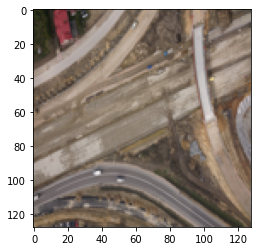

In [82]:
plt.imshow(train_X[100])

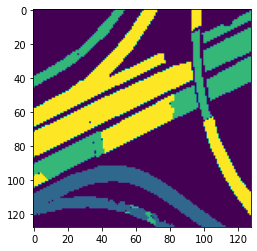

In [39]:
plt.imshow(train_Y[100])

In [83]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  return pred_mask

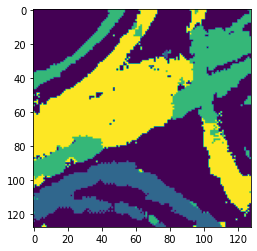

In [85]:
plt.imshow(create_mask(predicted[100]))

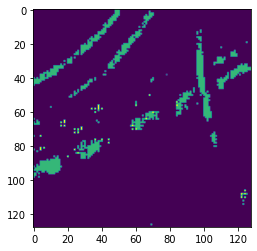

In [41]:
plt.imshow(create_mask(predicted[100]))

In [47]:
res = np.array(list(map(create_mask, predicted)))

In [87]:
predicted_test = model.predict(valid_X)

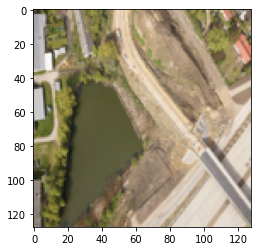

In [88]:
plt.imshow(valid_X[0])

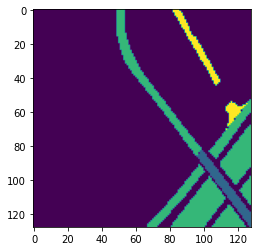

In [89]:
plt.imshow(valid_Y[0])


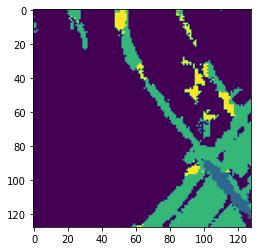

In [90]:
plt.imshow(create_mask(predicted_test[0]))